In [1]:
import snap as sn
G = sn.TNGraph()

nodes = [a.replace("\n", "") for a in open("nodelist.unique", "r").readlines()]
edges = [(int(a[0]), int(a[1])) for a in
         [b.replace("\n", "").split(" ") for b in open("edgelist.enc", "r").readlines()]]

for i in range(len(nodes)):
    G.AddNode(i)
    
for (n1, n2) in edges:
    G.AddEdge(n1, n2)
    

In [2]:
certids = {a[0]: " ".join(a[1:]) for a in
           [b.replace("\n", "").split(" ") for b in open("id.1", "r").readlines()]}

In [3]:
certids

{'000-000-0000.com': "('cPanel, Inc. Certification Authority', 'cPanel, Inc.', None, 2110387998)",
 '000000.ads.tremorhub.com': "('Amazon', 'Amazon', 'Server CA 1B', 328907731)",
 '000001-whitelabel.property.datahc.com': '("Let\'s Encrypt Authority X3", "Let\'s Encrypt", None, 125024875)',
 '000002-whitelabel.property.datahc.com': '("Let\'s Encrypt Authority X3", "Let\'s Encrypt", None, 1126231984)',
 '00000.home.itsonsaas.net': '("Let\'s Encrypt Authority X3", "Let\'s Encrypt", None, 3715960189)',
 '0-000.suitablenames.com': '("Let\'s Encrypt Authority X3", "Let\'s Encrypt", None, 995864029)',
 '00010110.xyz': '("Let\'s Encrypt Authority X3", "Let\'s Encrypt", None, 3049464310)',
 '0003.co.jp': "('SECOM Passport for Web SR 3.0 CA', 'SECOM Trust Systems CO.,LTD.', None, 3906103527)",
 '0004116.com': "('TrustAsia TLS RSA CA', 'TrustAsia Technologies, Inc.', 'Domain Validated SSL', 1756811637)",
 '00066bei.com': "('CloudFlare Inc ECC CA-2', 'CloudFlare, Inc.', None, 1292157082)",
 '0008.

In [4]:
G.GetEdges()

15716515

In [6]:
certids['pantheon.io'] == certids['batterychargers.com']

True

In [7]:
suspect_edges = []
none_edges = []

e = G.BegEI()

for _ in range(G.GetEdges()):
    n1, n2 = e.GetId()
    c1 = certids.get(nodes[n1], "-")
    c2 = certids.get(nodes[n2], "-")
    
    if c1 == "-" or c2 == "-":
        none_edges.append((nodes[n1], c1, nodes[n2], c2))
    elif c1 != c2:
        suspect_edges.append((nodes[n1], c1, nodes[n2], c2))
        
    e.Next()

In [8]:
len(suspect_edges)

1525003

In [9]:
len(none_edges)

2459400

In [10]:
G.GetEdges() - len(suspect_edges) - len(none_edges)

11732112

In [11]:
import pickle
with open("suspect_edges_diff_cert_id.pickle", "wb") as f:
    pickle.dump(suspect_edges, f)

In [12]:
with open("none_edges.pickle", "wb") as f:
    pickle.dump(none_edges, f)

In [35]:
eval(suspect_edges[0][3])[1]

"Let's Encrypt"

In [15]:
import pandas as pd

In [36]:
from collections import Counter
import tqdm

source = Counter()
victim = Counter()

for e in tqdm.tqdm(suspect_edges):
    s = eval(e[1])[1]
    v = eval(e[3])[1]
    
    source.update([s])
    victim.update([v])

100%|██████████| 1525003/1525003 [00:26<00:00, 57015.01it/s]


In [40]:
victim.most_common(3)

[('DigiCert Inc', 361568),
 ("Let's Encrypt", 348367),
 ('CloudFlare, Inc.', 209236)]

In [50]:
source_df = pd.DataFrame.from_dict(source, orient='index').reset_index()
victim_df = pd.DataFrame.from_dict(victim, orient='index').reset_index()

In [51]:
source_df = source_df.rename(columns={'index': 'CA', 0: 'frequency'})

In [52]:
victim_df = victim_df.rename(columns={'index': 'CA', 0: 'frequency'})

In [53]:
source_df

,CA,frequency
0,"cPanel, Inc.",5546
1,Amazon,23699
2,Let's Encrypt,491402
3,DigiCert Inc,412859
4,"GoDaddy.com, Inc.",15440
...,...,...
140,MULTICERT - Serviços de Certificação Electróni...,6
141,SSL Corp,4
142,Franklin Templeton Investments,366
143,"WEDOS Internet, a.s.",1


In [60]:
source_df.sort_values(by=['frequency'], ascending=False)

,CA,frequency
2,Let's Encrypt,491402
3,DigiCert Inc,412859
11,GlobalSign nv-sa,206990
8,COMODO CA Limited,81976
18,Google Trust Services,69569
...,...,...
118,"VeriSign, Inc.",1
119,Microsec Ltd.,1
120,IdenTrust,1
123,Dhimyotis,1


In [61]:
source_summary = source_df.sort_values(by=['frequency'], ascending=False)
source_summary = source_summary.reset_index()


,index,CA,frequency
0,2,Let's Encrypt,491402
1,3,DigiCert Inc,412859
2,11,GlobalSign nv-sa,206990
3,8,COMODO CA Limited,81976
4,18,Google Trust Services,69569
...,...,...,...
140,118,"VeriSign, Inc.",1
141,119,Microsec Ltd.,1
142,120,IdenTrust,1
143,123,Dhimyotis,1


In [73]:
other_freq = source_summary.iloc[10:]['frequency'].sum()
source_summary = source_summary.iloc[:10]
source_summary = source_summary.append([{"CA": "Other", "frequency": other_freq}])

In [76]:
victim_summary = victim_df.sort_values(by=['frequency'], ascending=False)
victim_summary = victim_summary.reset_index()
other_freq = victim_summary.iloc[10:]['frequency'].sum()
victim_summary = victim_summary.iloc[:10]
victim_summary = victim_summary.append([{"CA": "Other", "frequency": other_freq}])


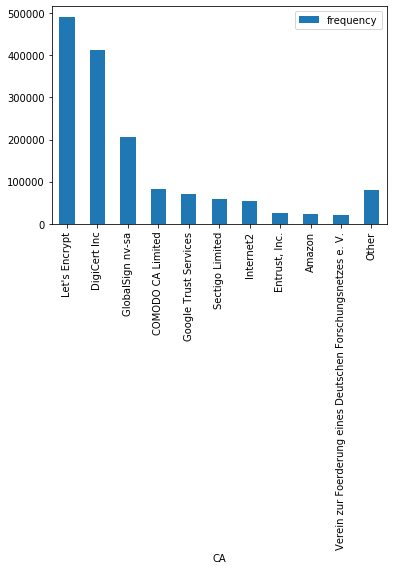

In [78]:
source_summary.plot(x='CA', y='frequency', kind='bar')

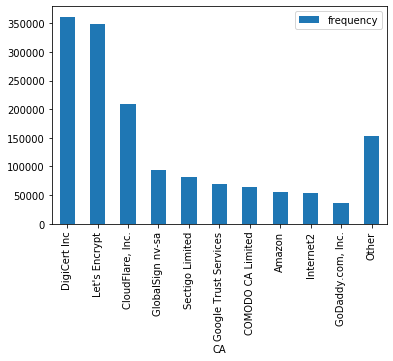

In [79]:
victim_summary.plot(x='CA', y='frequency', kind='bar')

In [ ]:
#Filter where the CAs are different.
